In [1]:
from pandas import *
import pandasql

def num_rainy_days(tw):
# number of rainy days

    q = "select rain,count(*) as rd from tw group by rain"
    
    rainy_days = pandasql.sqldf(q.lower(), locals())
    return rainy_days

def mean_temp_aggregate_by_fog(tw):
# mean temp by fog

    q = "select fog, max(meantempi) as meantemp from tw group by fog"
    
    foggy_days = pandasql.sqldf(q.lower(), locals())
    return foggy_days

def mean_weekend_temperature(tw):
# mean temp on weekends

    q = "select avg(meantempi) as avgtemp from tw where day_week in (0,6) "

    mean_temp_weekends = pandasql.sqldf(q.lower(), locals())
    return mean_temp_weekends['avgtemp'][0]

def avg_temp_rain(tw):
# mean temp when raining

    q = "select avg(tempi) as avgtemp from tw where tempi>55 and rain=1"

    avg_min_temp_rainy = pandasql.sqldf(q.lower(), locals())
    return avg_min_temp_rainy['avgtemp'][0]

def reformat_date (tw):
# reformat date to mach yyyy-mm-dd format

    tw2 = tw
    tw2['DATEnew'] = tw2['DATEn'].map(lambda x: (datetime.strptime(x,"%m-%d-%y")).strftime("%Y-%m-%d"))

    return tw2

if True:
    turnstile_weather = pandas.read_csv("/Users/wilfriedhoge/Dropbox/udacity/improved-turnstile-dataset/turnstile_weather_v2.csv")
    
    rainy_days = num_rainy_days(turnstile_weather)
    print rainy_days
    
    foggy = mean_temp_aggregate_by_fog(turnstile_weather)
    print foggy
    
    weekend_temp = mean_weekend_temperature(turnstile_weather)
    print "Avg. temp on weekends:", weekend_temp
    
    rain_temp = avg_temp_rain(turnstile_weather)
    print "Avg. temp when raining:", rain_temp
    
    turnstile_weather = reformat_date(turnstile_weather)
    
    #print turnstile_weather.head(5)
    print list(turnstile_weather)

   rain     rd
0     0  33064
1     1   9585
   fog  meantemp
0    0     79.80
1    1     71.76
Avg. temp on weekends: 62.4215908266
Avg. temp when raining: 60.8059011589
['UNIT', 'DATEn', 'TIMEn', 'ENTRIESn', 'EXITSn', 'ENTRIESn_hourly', 'EXITSn_hourly', 'datetime', 'hour', 'day_week', 'weekday', 'station', 'latitude', 'longitude', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi', 'weather_lat', 'weather_lon', 'DATEnew']


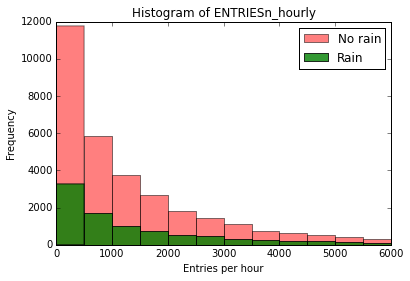

In [44]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

def entries_histogram(turnstile_weather):

    raindata = turnstile_weather[turnstile_weather["rain"]==1].reset_index()["ENTRIESn_hourly"]
    noraindata = turnstile_weather[turnstile_weather["rain"]==0].reset_index()["ENTRIESn_hourly"]
    heavyrain = turnstile_weather[turnstile_weather["precipi"]>.1].reset_index()["ENTRIESn_hourly"]

    plt.figure()
    bins = np.linspace(0, 6000, 13)

    plt.hist(noraindata, bins, color='red', alpha=0.5, label='No rain')
    plt.hist(raindata, bins, color='green', alpha=0.8, label='Rain')
    #plt.hist(heavyrain, bins, color='blue', alpha=0.8, label='Heavy rain')
    plt.legend()
    
    plt.xlabel('Entries per hour')
    plt.ylabel('Frequency')
    plt.xlim(0,6000)
    plt.title('Histogram of ENTRIESn_hourly')
        
    return 

if True:
    entries_histogram(turnstile_weather)

In [3]:
import numpy as np
import scipy
import scipy.stats
import pandas

def mann_whitney_plus_means(turnstile_weather):
    
    raindata = turnstile_weather[turnstile_weather["rain"]==1]["ENTRIESn_hourly"]
    noraindata = turnstile_weather[turnstile_weather["rain"]==0]["ENTRIESn_hourly"]
    
    
    with_rain_mean = np.mean(raindata)
    without_rain_mean = np.mean(noraindata)
    
    ret = scipy.stats.mannwhitneyu(raindata, noraindata)
    U = ret[0]
    p = ret[1]
    
    return with_rain_mean, without_rain_mean, U, p 

if True: 
    
    print mann_whitney_plus_means(turnstile_weather)

(2028.1960354720918, 1845.5394386644084, 153635120.5, 2.7410695712437496e-06)


778.223557874
rain            -39.603903
meanprecipi      81.299428
hour            123.403996
meantempi       -13.843088
weekday         982.720007
unit_R003     -1639.715653
unit_R004     -1311.430532
unit_R005     -1315.761781
unit_R006     -1193.254765
unit_R007     -1478.941167
unit_R008     -1473.047539
unit_R009     -1524.938619
unit_R011      5533.408174
unit_R012      6876.665711
unit_R013       775.106571
unit_R016     -1036.019151
unit_R017      2390.101195
unit_R018      5968.736439
unit_R019      1426.428842
unit_R020      4566.197969
unit_R021      2887.711000
unit_R022      7710.590442
unit_R023      4345.767862
unit_R024      1392.936673
unit_R025      3523.321316
unit_R027      1160.203346
unit_R029      5422.176464
unit_R030      1292.370012
unit_R031      2544.138829
unit_R032      2643.640449
                  ...     
unit_R321      -688.689128
unit_R322        10.910201
unit_R323      -468.974938
unit_R325     -1415.170041
unit_R330      -770.326553
unit_R335     

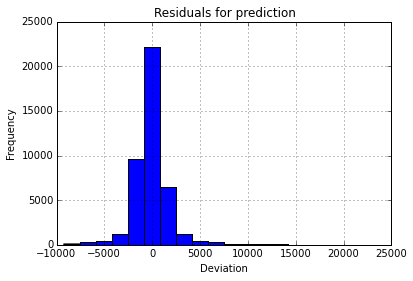

In [6]:
import numpy as np
import pandas
import statsmodels.api as sm
import sys

def linear_regression(features, values):
    
    features = sm.add_constant(features)

    model = sm.OLS(values, features)
    results = model.fit()
    
    return results.params[0],results.params[1:]

def predictions(dataframe):
    
    features = dataframe[['rain', 'meanprecipi', 'hour', 'meantempi','weekday']]

#    features = dataframe[['hour', 'weekday']]
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)

    #print features
    
    # Values
    values = dataframe['ENTRIESn_hourly']

    # Perform linear regression
    intercept, params = linear_regression(features, values)

    print intercept
    print params
    
    predictions = intercept + np.dot(features, params)
    return predictions

def plot_residuals(turnstile_weather, predictions):

    plt.figure()
    (turnstile_weather['ENTRIESn_hourly'] - predictions).hist(bins=20)

    plt.xlabel('Deviation')
    plt.ylabel('Frequency')
    plt.title(r'Residuals for prediction')
    
    return plt

def compute_r_squared(data, predictions):

    sumy = ((data-np.mean(data))**2).sum()
    sump = ((data-predictions)**2).sum()
     
    return 1- sump / sumy

if True:
    
    pred = predictions(turnstile_weather)
#    print turnstile_weather.shape, pred.shape
    
    plot_residuals(turnstile_weather, pred)
    print "R^2: ", compute_r_squared(turnstile_weather["ENTRIESn_hourly"], pred)

In [7]:
import numpy as np
import pandas
import sklearn
from sklearn.linear_model import SGDRegressor

def normalize_features(features):
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

def recover_params(means, std_devs, norm_intercept, norm_params):
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

def linear_regression(features, values):
    
    clf = sklearn.linear_model.SGDRegressor(n_iter=20)
    clf.fit(features, values)
    pp = clf.get_params()

    return clf.intercept_, clf.coef_

def predictions_skl(dataframe):
    
    #features = dataframe[['rain', 'precipi', 'hour', 'meantempi']]
    features = dataframe[['rain', 'meanprecipi', 'hour', 'meantempi','weekday']]

    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe['ENTRIESn_hourly']
    
    # Get numpy arrays
    features_array = features.values
    values_array = values.values
    
    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)
    
    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
    print intercept
    print params
    
    predictions = intercept + np.dot(features_array, params)
    # The following line would be equivalent:
    # predictions = norm_intercept + np.dot(normalized_features_array, norm_params)
    
    return predictions

if True:
    
    pred = predictions_skl(turnstile_weather)
    
    print "R^2: ", compute_r_squared(turnstile_weather["ENTRIESn_hourly"], pred)

[ 835.0515034]
[  6.86825781e+01   7.21214204e+01   1.27727382e+02  -1.52053583e+01
   1.00744302e+03  -2.15673846e+03  -1.44516169e+03  -1.38707987e+03
  -1.28619806e+03  -1.85919955e+03  -1.45342670e+03  -1.53544277e+03
   4.55538436e+03   6.95257086e+03   1.34379466e+03  -1.34015155e+03
   2.98691809e+03   7.02887566e+03   1.66744475e+03   4.59699537e+03
   2.37612755e+03   6.95038960e+03   3.66626434e+03   9.67401951e+02
   2.50015705e+03   1.95335328e+03   6.90138900e+03   1.67632298e+03
   2.07265643e+03   1.76810654e+03   4.21867043e+03  -7.75675584e+02
   6.07642848e+02  -7.86979928e+02  -9.53315261e+02  -1.61849767e+03
  -1.02618518e+03  -4.46745976e+02   1.49366369e+03  -1.28716504e+03
   9.11915084e+02   3.04104259e+03   7.54038425e+03   4.84708104e+02
   3.06567163e+03   3.72772676e+03  -8.34283368e+02   1.33383963e+03
  -6.13998588e+02   5.90944268e+03  -5.60087287e+02   2.57983231e+03
  -1.00086271e+03  -5.94946831e+02  -9.33656515e+02  -1.24569668e+03
   1.13168062e+03  

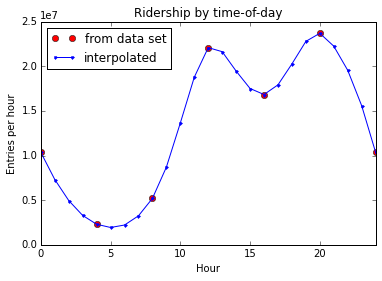

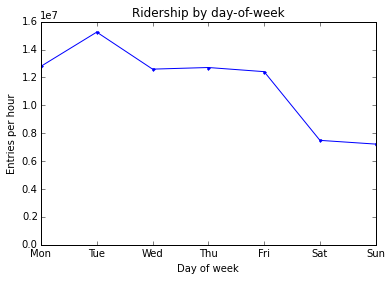

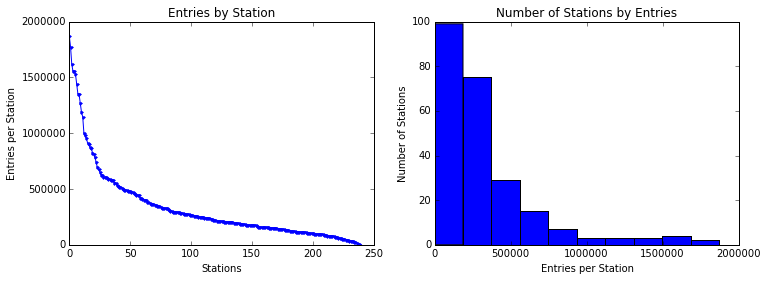

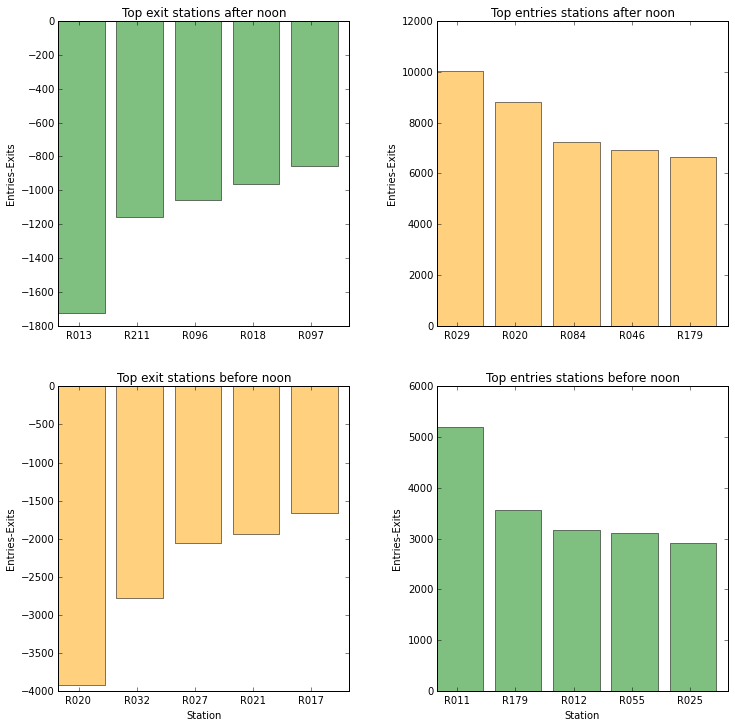

In [18]:
"""
     * Ridership by time-of-day or day-of-week
     * How ridership varies by subway station (UNIT)
     * Which stations have more exits or entries at different times of day
       (You can use UNIT as a proxy for subway station.)
"""

import numpy as np
import pandas
import pandasql
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.mlab import stineman_interp
from numpy import linspace

def ridership_by_hour(tw):

    q = "select hour,sum(ENTRIESn_hourly) as sume from tw group by hour"
    tw_eh = pandasql.sqldf(q.lower(), locals())
    
    plt.figure()

    x = tw_eh['hour']
    x[6] = 24
    y = tw_eh['sume'] 
    y[6] = y[0]
    yp = None
    xi = linspace(0,24,25);
    yi = stineman_interp(xi,x,y,yp);

    p1 = plt.plot(x,y,'ro',label='from data set')
    p2 = plt.plot(xi,yi,'-b.',label='interpolated')
    
    plt.xlabel('Hour')
    plt.ylabel('Entries per hour')
    plt.title('Ridership by time-of-day')
    plt.xlim(0,24)
    plt.legend(loc='upper left')
    
    plt.show()    
    
    return plt

def ridership_by_day(tw):

    q = "select day_week as day,sum(ENTRIESn_hourly) as sume from tw group by day_week"
    tw_eh = pandasql.sqldf(q.lower(), locals())

    plt.figure()

    x = tw_eh['day']
    y = tw_eh['sume'] 
    plt.plot(x,y,'-b.')

    ax = plt.gca()
    ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

    plt.xlabel('Day of week')
    plt.ylabel('Entries per hour')
    plt.title('Ridership by day-of-week')
    plt.xlim(0,6)
    plt.ylim(0,1.6e7)

    plt.show()    
    
    return plt

def ridership_by_unit(tw):

    q = "select unit, sum(ENTRIESn_hourly) as sume from tw group by unit order by 2 desc"
    tw_eh = pandasql.sqldf(q.lower(), locals())

    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))

    x = tw_eh.index
    y = tw_eh['sume'] 
    ax0.plot(x,y,'-b.')
    
    ax0.set_xlabel('Stations')
    ax0.set_ylabel('Entries per Station')
    ax0.set_title('Entries by Station')

    ax1.hist(tw_eh['sume'])
    ax1.set_xlabel('Entries per Station')
    ax1.set_ylabel('Number of Stations')
    ax1.set_title('Number of Stations by Entries')
    
    plt.show()    
    
    return plt

def hig_freq_units(tw):

    q = "select unit, avg(ENTRIESn_hourly-EXITSn_hourly) as diffe from tw where hour > 12 group by unit order by 2 limit 5"
    tw_eh1 = pandasql.sqldf(q.lower(), locals())

    q = "select unit, avg(ENTRIESn_hourly-EXITSn_hourly) as diffe from tw where hour > 12 group by unit order by 2 desc limit 5"
    tw_eh2 = pandasql.sqldf(q.lower(), locals())

    q = "select unit, avg(ENTRIESn_hourly-EXITSn_hourly) as diffe from tw where hour <= 12 group by unit order by 2 limit 5"
    tw_eh3 = pandasql.sqldf(q.lower(), locals())

    q = "select unit, avg(ENTRIESn_hourly-EXITSn_hourly) as diffe from tw where hour <= 12 group by unit order by 2 desc limit 5"
    tw_eh4 = pandasql.sqldf(q.lower(), locals())
        
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

    ind = np.arange(5)
    width = 0.35
    
    ax2.bar(ind, tw_eh3['diffe'], color='orange', alpha=.5)
    ax2.set_xticks(ind+width)
    ax2.set_xticklabels(tw_eh3['UNIT'])    
    ax2.set_xlabel('Station')
    ax2.set_ylabel('Entries-Exits')
    ax2.set_title('Top exit stations before noon')

    ax3.bar(ind, tw_eh4['diffe'], color='green', alpha=.5)
    ax3.set_xticks(ind+width)
    ax3.set_xticklabels(tw_eh4['UNIT'])    
    ax3.set_xlabel('Station')
    ax3.set_ylabel('Entries-Exits')
    ax3.set_title('Top entries stations before noon')
    
    ax0.bar(ind, tw_eh1['diffe'], color='green', alpha=.5)
    ax0.set_xticks(ind+width)
    ax0.set_xticklabels(tw_eh1['UNIT'])    
    #ax0.set_xlabel('Unit')
    ax0.set_ylabel('Entries-Exits')
    ax0.set_title('Top exit stations after noon')

    ax1.bar(ind, tw_eh2['diffe'], color='orange', alpha=.5)
    ax1.set_xticks(ind+width)
    ax1.set_xticklabels(tw_eh2['UNIT'])    
    #ax1.set_xlabel('Unit')
    ax1.set_ylabel('Entries-Exits')
    ax1.set_title('Top entries stations after noon')

    plt.subplots_adjust(wspace = .3)
    
    plt.show()    

    return
    
if True:
    
    ridership_by_hour(turnstile_weather)
    ridership_by_day(turnstile_weather)
    ridership_by_unit(turnstile_weather)    
    hig_freq_units(turnstile_weather)
    